# Deep and Cross Network
## Keras implementation based on the paper arxiv.org/abs/1708.05123

In [1]:
import yaml
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import keras.backend as K
from keras.backend import squeeze
from keras import layers
from keras import regularizers
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate, Lambda, Add
from keras.layers import BatchNormalization
from keras.callbacks import Callback
from keras.optimizers import Adam
from keras.models import Model
from keras.utils import plot_model, np_utils
from sklearn.metrics import roc_auc_score
import os
import time
from tqdm import tqdm, tqdm_notebook, tnrange

import matplotlib.pyplot as plt
from IPython.display import Image

SEED = 123
from tensorflow import set_random_seed

%matplotlib inline

Using TensorFlow backend.


In [2]:
print("tensorflow version: %s"%tf.__version__)

tensorflow version: 1.10.0


In [3]:
sess = tf.Session()
K.set_session(sess)
K.set_learning_phase(0)

In [4]:
with open("config.yml", 'r') as ymlfile:
    cfg = yaml.load(ymlfile)
    filename = cfg['filename']
    x_col_cat = cfg['features']['categorical']
    x_col_bin = cfg['features']['binary']
    x_col_num = cfg['features']['numerical']
    x_col_cyc = cfg['features']['cyclical']
    y_col = cfg['features']['label']
    w_col = cfg['features']['weight']

In [5]:
nrows=1e6
df = pd.read_csv(filename, nrows=nrows)
print("dataset size: %s"%str(df.shape))
print("ctr = %.5f"%((df[y_col]*df[w_col]).sum()*1./df[w_col].sum()))

dataset size: (602733, 30)
ctr = 0.00952


In [6]:
def merge_columns(arr):
    arr = arr.astype(str)
    vals = (arr[:,0].astype(object)+'_'+arr[:,1].astype(object))
    for i in range(2, arr.shape[1]):
        vals = (vals+'_'+arr[:,i].astype(object))
    return vals

In [7]:
cat_features = []
for f in x_col_cat:
    if(isinstance(f, str)==False):
        df[list(f.values())[0]] = df[list(f.values())[0]].fillna('unknown')
        df[list(f.keys())[0]] = merge_columns(df[list(f.values())[0]].values)
        cat_features.append(list(f.keys())[0])
    else:
        df[f] = df[f].fillna('unknown')
        cat_features.append(f)
print(cat_features)

['geo_state', 'geo_country', 'geo_city', 'zip_code', 'category_1', 'domain', 'app_bundle', 'publisher_id', 'device_type', 'device_os', 'device_os_version', 'device_browser', 'device_browser_version', 'carrier', 'language', 'exchange_id', 'banner_type', 'account_campaign', 'account_banner', 'account_advertiser', 'account_offer']


In [8]:
binary_features = []
for f in x_col_bin:
    uniques = df[f].unique()
    d = {uniques[0]:0, uniques[1]:1}
    df[f] = df[f].map(d)
    binary_features.append(f)
    print(f, d)
print(binary_features)

is_interstitial {'Yes': 1, 'No': 0}
is_mobile_web_optimized {'Yes': 1, 'No': 0}
is_app {'Yes': 0, 'No': 1}
['is_interstitial', 'is_mobile_web_optimized', 'is_app']


In [9]:
cyc_features = []
for f in x_col_cyc:
    nuniques = df[f].nunique()
    df[f+'_sin'] = np.sin(df[f]*(2.*np.pi/nuniques))
    df[f+'_cos'] = np.cos(df[f]*(2.*np.pi/nuniques))
    cyc_features.append(f+'_sin')
    cyc_features.append(f+'_cos')
    print(f, nuniques)
print(cyc_features)

user_day_of_week 7
user_hour 24
['user_day_of_week_sin', 'user_day_of_week_cos', 'user_hour_sin', 'user_hour_cos']


### Encoding

In [10]:
def binary_encode(s, modulo, required_bits=8):
    num = hash(s) % modulo
    return np.array(list(np.binary_repr(num).zfill(required_bits))).astype(np.int8)

def hashing_trick(s, modulo):
    num = hash(s) % modulo
    arr = np.zeros((modulo)).astype(np.int8)
    arr[num] = 1
    return arr

def get_sparse_index(s, modulo):
    return hash(s) % modulo

#### Combine columns

In [11]:
df = df[cat_features + binary_features + cyc_features + [y_col] + [w_col]]

Here we represent categorical features as sparse index. In production system this encoding can be done by maintaining a map of unique values per feature. A Bloom filter can be used to track each value on the fly by checking whether a specific value exists and update the counters accordingly

In [12]:
cat_cols = {}
column_instance_dict = {}
modulos = []
for col in tqdm(cat_features):
    modulo = df[col].nunique()
    cat_cols[col] = modulo
    modulos.append(modulo)
    column_instance_dict[col] = dict(zip(df[col].unique(), range(len(df[col].unique()))))
    df[col] = df[col].map(column_instance_dict[col])
for c in cat_features:
    print("%-25s %-5d"%(c, cat_cols[c]))

100%|██████████| 21/21 [00:02<00:00,  9.27it/s]

geo_state                 642  
geo_country               13   
geo_city                  5412 
zip_code                  9629 
category_1                58   
domain                    4990 
app_bundle                3570 
publisher_id              2614 
device_type               6    
device_os                 11   
device_os_version         140  
device_browser            27   
device_browser_version    893  
carrier                   664  
language                  78   
exchange_id               7    
banner_type               3    
account_campaign          20   
account_banner            60   
account_advertiser        8    
account_offer             11   


In [13]:
embed_dict = {}
for c in cat_cols:
    if(cat_cols[c]<=10):
        embed_dict[c] = 3
    elif(cat_cols[c]<=100):
        embed_dict[c] = 5
    else:
        embed_dict[c] = 10
embed_dict

{'account_advertiser': 3,
 'account_banner': 5,
 'account_campaign': 5,
 'account_offer': 5,
 'app_bundle': 10,
 'banner_type': 3,
 'carrier': 10,
 'category_1': 5,
 'device_browser': 5,
 'device_browser_version': 10,
 'device_os': 5,
 'device_os_version': 10,
 'device_type': 3,
 'domain': 10,
 'exchange_id': 3,
 'geo_city': 10,
 'geo_country': 5,
 'geo_state': 10,
 'language': 5,
 'publisher_id': 10,
 'zip_code': 10}

In [14]:
x_cols = [c for c in df.columns if (c != 'clicks') and (c != 'impressions')]
print("number of x columns: %d"%(len(x_cols)))

number of x columns: 28


### Prepare data for keras and split

In [15]:
dim = df.shape[0]
dim_train = int(0.6*dim)
dim_val = int(0.2*dim)
dim_test = dim - dim_train - dim_val
df = df.sample(frac=1).reset_index(drop=True)
df_train, df_val, df_test = df.iloc[:dim_train], df.iloc[dim_train:(dim_train+dim_val)], df.iloc[(dim_train+dim_val):]
print("train: %d val: %d test: %d"%(df_train.shape[0], df_val.shape[0], df_test.shape[0]))

train: 361639 val: 120546 test: 120548


In [16]:
X_train = [df_train[i].values.reshape(dim_train,1) for i in cat_features]
X_train.append(df_train[binary_features + cyc_features].values.reshape(dim_train, 1, len(binary_features + cyc_features)))
y_train, w_train = np.array(df_train['clicks']), np.array(df_train['impressions'])

X_val = [df_val[i].values.reshape(dim_val,1) for i in cat_features]
X_val.append(df_val[binary_features + cyc_features].values.reshape(dim_val, 1, len(binary_features + cyc_features)))
y_val, w_val = np.array(df_val['clicks']), np.array(df_val['impressions'])

X_test = [df_test[i].values.reshape(dim_test,1) for i in cat_features]
X_test.append(df_test[binary_features + cyc_features].values.reshape(dim_test, 1, len(binary_features + cyc_features)))
y_test, w_test = np.array(df_test['clicks']), np.array(df_test['impressions'])

## Build Model

### Define Hyperparameters

In [17]:
def exp_decay(epoch):
    initial_lrate = 0.0005
    k = 0.2
    lrate = initial_lrate * np.exp(-k*epoch)
    print("current lr: %f"%(lrate))
    return lrate

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.15
    epochs_drop = 2
    lrate = initial_lrate * drop**np.floor((1+epoch)/epochs_drop)
    print("current lr: %f"%(lrate))
    return lrate

lrate = keras.callbacks.LearningRateScheduler(exp_decay)

In [18]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, min_delta=0.0001, baseline=0.55)

### Current best configuration:
- m_embed = 10
- units = 200
- n_dl = 3
- n_cl = 2
- dropout = 0.5
- lr = 1e-3
- decay = 1e-3
- l2 = 0.000
- epochs = 100
- batch_size = 2**19

### Even better configuration: Cross & Deep & Wide
- units_d = 100
- units_w = 300
- n_dl = 5
- n_cl = 1
- dropout = 0.5
- lr = 1e-3
- decay = 1e-4
- l2 = 0.000
- epochs = 150
- batch_size = 2**19

In [128]:
units_d = 100
units_w = 300
n_dl = 5
n_cl = 1
dropout = 0.5
lr = 1e-3
decay = 1e-4
l2 = 0.000

epochs = 150
batch_size = 2**19

### Define Network layers

In [129]:
class CrossLayer(layers.Layer):
    def __init__(self, output_dim, x0, **kwargs):
        self.output_dim = output_dim
        self.x0 = x0
        super(CrossLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_dim = input_shape[2]
        self.W = self.add_weight(shape = [1, self.input_dim], 
                                 initializer = 'uniform', 
                                 name = 'w_',
                                 trainable = True)
        self.bias = self.add_weight(shape = [1, self.input_dim], 
                                    initializer = 'uniform', 
                                    name = 'b_', 
                                    trainable = True)
        super(CrossLayer, self).build(input_shape)

    def call(self, x):
        cross = Lambda(lambda _: K.batch_dot(K.dot(x, K.transpose(self.W)), self.x0) + self.bias + self.x0)(x)
        return cross

    def compute_output_shape(self, input_shape):
        return input_shape

parameters: 423100


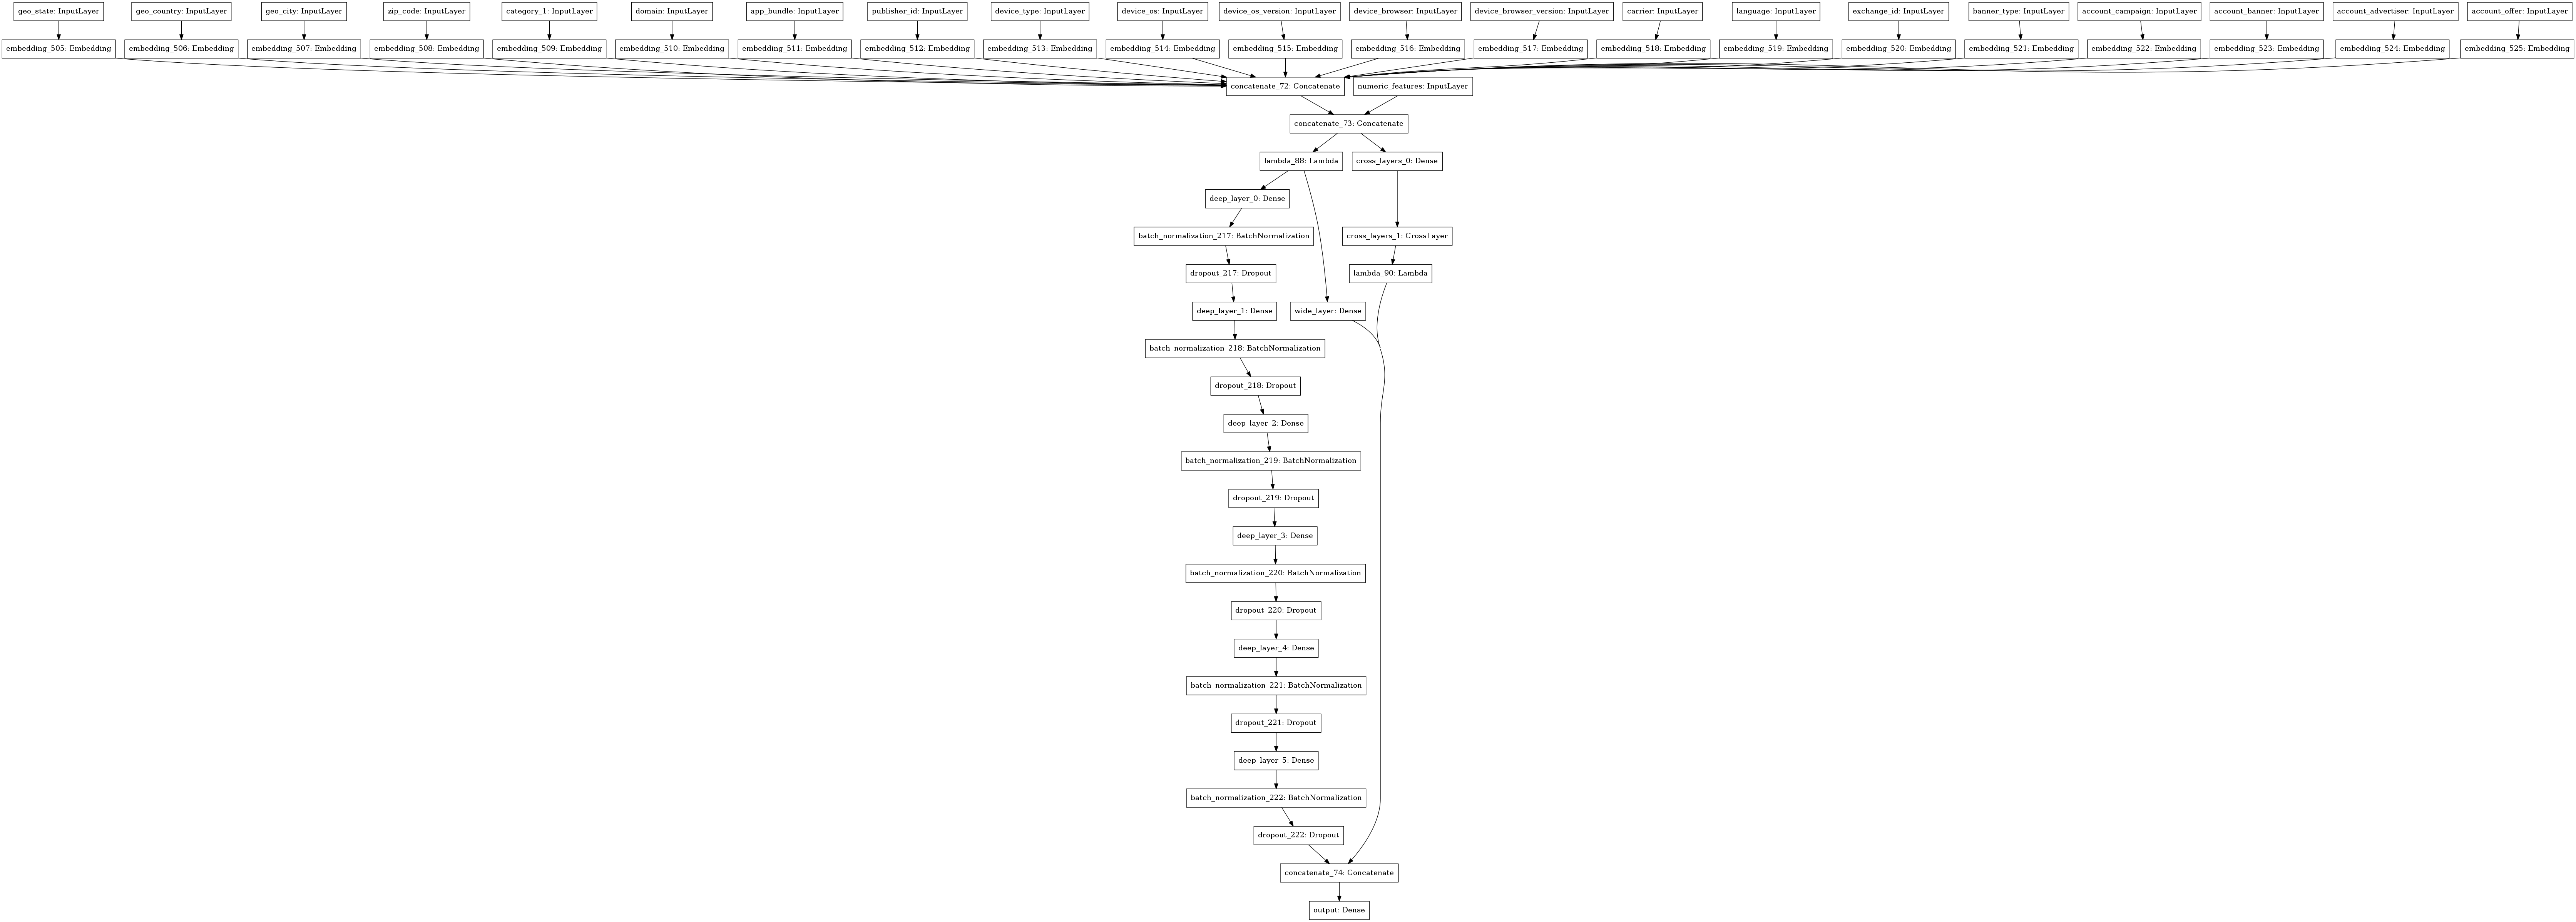

In [130]:
np.random.seed(SEED)
set_random_seed(SEED)

input_layers = []
embbedding_layers = []
for i in cat_features:
    input_layers.append(Input(shape=(1,), name=i))
    embbedding_layers.append(Embedding(input_dim=cat_cols[i], output_dim=embed_dict[i])(input_layers[-1]))
fe = concatenate(embbedding_layers, axis=2)
in_nums = Input(shape=(1, len(binary_features + cyc_features)), name='numeric_features')
input_layers.append(in_nums)
x0 = concatenate([fe, in_nums], axis=2)

# Deep layers
x0_l = Lambda(lambda y: squeeze(y, axis=1))(x0)
x_dl = Dense(units_d, 
             activation='relu', 
             kernel_regularizer=regularizers.l2(l2),
             name = "deep_layer_0")(x0_l)
x_dl = BatchNormalization()(x_dl)
x_dl = Dropout(dropout)(x_dl, training=False)
for i in range(n_dl):
    x_dl = Dense(int(units_d), 
                 activation='relu',
                 kernel_regularizer=regularizers.l2(l2),
                 name = "deep_layer_"+str(i+1))(x_dl)
    x_dl = BatchNormalization()(x_dl)
    x_dl = Dropout(dropout)(x_dl, training=False)

    
# Wide layers
x_wl = Dense(units_w, 
             activation='linear', 
             kernel_regularizer=regularizers.l2(l2),
             name = "wide_layer")(x0_l)  
    
# Cross layers
x_cl = Dense(units=x0.shape[2].value, 
             activation='linear',
             kernel_regularizer=regularizers.l2(l2),
             name="cross_layers_0")(x0)
for i in range(n_cl):
    x_cl = CrossLayer(output_dim=x0.shape[2].value, 
                      x0=x0, 
                      name="cross_layers_"+str(i+1))(x_cl)
x_cl = Lambda(lambda y: squeeze(x_cl, axis=1))(x_cl)

x_comb = concatenate([x_cl, x_dl, x_wl], axis=-1)
out = Dense(1, activation='sigmoid', name='output')(x_comb)

model = Model(inputs=input_layers, outputs=out)

# model.summary()
plot_model(model, to_file='model.png')
optimizer = keras.optimizers.Adam(lr=lr, decay=decay)
loss = 'binary_crossentropy'
model.compile(loss=loss, optimizer=optimizer)
print("parameters: %d"%model.count_params())
Image("model.png")

In [131]:
batch_epochs = 1
start_time = time.time()
losses = {'loss':[], 'val_loss':[]}
for i in range(batch_epochs):
    history = model.fit(x=X_train, y=y_train, sample_weight=w_train, 
              batch_size=batch_size, epochs=epochs,# callbacks=callbacks,
              validation_data=(X_val, y_val), verbose=1, shuffle=True)#, callbacks=[lrate])
    losses['loss'].extend(history.history['loss'])
    losses['val_loss'].extend(history.history['val_loss'])
    pp = np.round(a=model.predict(X_val).ravel(),decimals=7)
    print(i, "auc", np.round(roc_auc_score(y_val, pp, sample_weight=w_val), 3), "calibration", np.round(pp.dot(w_val)/y_val.dot(w_val), 3))
end_time = time.time()
print("Finished training %d epochs in %d.1f min"%(epochs, (end_time-start_time)/60.))

Train on 361639 samples, validate on 120546 samples
Epoch 1/150
361639/361639 [==============================] - 7s 21us/step - loss: 0.9529 - val_loss: 0.2216
Epoch 2/150
361639/361639 [==============================] - 1s 2us/step - loss: 0.2317 - val_loss: 0.1194
Epoch 3/150
361639/361639 [==============================] - 1s 2us/step - loss: 0.1231 - val_loss: 0.6194
Epoch 4/150
361639/361639 [==============================] - 1s 2us/step - loss: 0.7932 - val_loss: 1.2302
Epoch 5/150
361639/361639 [==============================] - 1s 2us/step - loss: 1.5823 - val_loss: 1.2347
Epoch 6/150
361639/361639 [==============================] - 1s 2us/step - loss: 1.5886 - val_loss: 1.0972
Epoch 7/150
361639/361639 [==============================] - 1s 2us/step - loss: 1.4075 - val_loss: 0.9641
Epoch 8/150
361639/361639 [==============================] - 1s 2us/step - loss: 1.2340 - val_loss: 0.8368
Epoch 9/150
361639/361639 [==============================] - 1s 2us/step - loss: 1.0689 - v

Epoch 77/150
361639/361639 [==============================] - 1s 2us/step - loss: 0.0581 - val_loss: 0.0566
Epoch 78/150
361639/361639 [==============================] - 1s 2us/step - loss: 0.0579 - val_loss: 0.0565
Epoch 79/150
361639/361639 [==============================] - 1s 2us/step - loss: 0.0578 - val_loss: 0.0564
Epoch 80/150
361639/361639 [==============================] - 1s 2us/step - loss: 0.0577 - val_loss: 0.0564
Epoch 81/150
361639/361639 [==============================] - 1s 2us/step - loss: 0.0576 - val_loss: 0.0563
Epoch 82/150
361639/361639 [==============================] - 1s 2us/step - loss: 0.0575 - val_loss: 0.0563
Epoch 83/150
361639/361639 [==============================] - 1s 2us/step - loss: 0.0575 - val_loss: 0.0562
Epoch 84/150
361639/361639 [==============================] - 1s 2us/step - loss: 0.0574 - val_loss: 0.0562
Epoch 85/150
361639/361639 [==============================] - 1s 2us/step - loss: 0.0573 - val_loss: 0.0562
Epoch 86/150
361639/361639 [

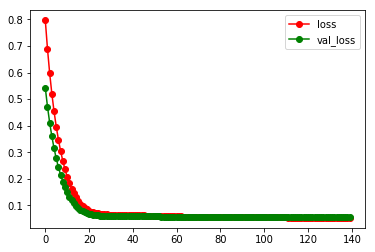

In [132]:
plt.plot(losses['loss'][10:], '-or', label='loss')
plt.plot(losses['val_loss'][10:], '-og', label='val_loss');
plt.legend();

## Calculate AUC and calibration metrics

In [133]:
for data in [[X_val, y_val, w_val, 'val'], [X_test, y_test, w_test, 'test'], [X_train, y_train, w_train, 'train']]:
    probs = model.predict(data[0]).ravel()
    sample_weight = data[2]
    print(data[3]+':')
    print("number of observations = %d"%(len(data[1])))
    print("\tAUC = %.4f"%(roc_auc_score(data[1], probs, sample_weight=sample_weight)))
    print("\tCalibration = %.4f"%(probs.dot(data[2])/data[1].dot(data[2])))
    print("\tctrpm = %.2f"%(1000*data[1].dot(data[2])/np.sum(data[2])))

val:
number of observations = 120546
	AUC = 0.8627
	Calibration = 0.9937
	ctrpm = 9.48
test:
number of observations = 120548
	AUC = 0.8687
	Calibration = 0.9777
	ctrpm = 9.72
train:
number of observations = 361639
	AUC = 0.8948
	Calibration = 0.9972
	ctrpm = 9.46


## Save the model for TFServing

In [299]:
export_path = 'models/dcnet/2'

In [300]:
inputs = {x.name:x for x in model.inputs}
outputs = {t.name:t for t in model.outputs}
inputs, outputs

({'account_advertiser_69:0': <tf.Tensor 'account_advertiser_69:0' shape=(?, 1) dtype=float32>,
  'account_banner_69:0': <tf.Tensor 'account_banner_69:0' shape=(?, 1) dtype=float32>,
  'account_campaign_69:0': <tf.Tensor 'account_campaign_69:0' shape=(?, 1) dtype=float32>,
  'account_offer_69:0': <tf.Tensor 'account_offer_69:0' shape=(?, 1) dtype=float32>,
  'app_bundle_69:0': <tf.Tensor 'app_bundle_69:0' shape=(?, 1) dtype=float32>,
  'banner_type_69:0': <tf.Tensor 'banner_type_69:0' shape=(?, 1) dtype=float32>,
  'carrier_69:0': <tf.Tensor 'carrier_69:0' shape=(?, 1) dtype=float32>,
  'category_1_69:0': <tf.Tensor 'category_1_69:0' shape=(?, 1) dtype=float32>,
  'device_browser_69:0': <tf.Tensor 'device_browser_69:0' shape=(?, 1) dtype=float32>,
  'device_browser_version_69:0': <tf.Tensor 'device_browser_version_69:0' shape=(?, 1) dtype=float32>,
  'device_os_69:0': <tf.Tensor 'device_os_69:0' shape=(?, 1) dtype=float32>,
  'device_os_version_69:0': <tf.Tensor 'device_os_version_69:0'

In [301]:
tf.saved_model.simple_save(
    sess,
    export_path,
    inputs=inputs,
    outputs=outputs)

INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: models/dcnet/2/saved_model.pb
